<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# CNN Text Classifier

by Fabian Märki

## Summary
The aim of this notebook is to build a CNN text classifier. It utilize pretrained word embeddings in order to take advantage of [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning) in NLP. Additionally, it sets the stage for hyperparameter tuning and model design optimization.

## Links
- [Enabling GPU on Google Colab](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm)

This notebook contains assigments: <font color='red'>Questions are written in red.</font>

<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/04_a_CNN_Text_Classifier.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab

import pandas as pd
import numpy as np

set_log_level()
import tensorflow as tf

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.19.0-41-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.12GB total and 23.99GB available
Tensorflow version: 2.12.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


Download the [cleaned](https://github.com/markif/2023_HS_CAS_NLP_LAB_Notebooks/blob/master/02_a_Text_Cleaning.ipynb) and [preprocessed](https://github.com/markif/2023_HS_CAS_NLP_LAB_Notebooks/blob/master/02_b_Text_Normalization.ipynb) doctor reviews dataset. 

In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 6.76 s, sys: 1.54 s, total: 8.3 s
Wall time: 4.5 s


Exclude *neutral* ratings so that the task becomes a binary classification.

In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


Import some helper functions (later we will overwrite some functions in order to provide a better understanding of the process)...

In [6]:
from fhnw.nlp.utils.ploting import plot_history

from fhnw.nlp.utils.params import build_model_cnn
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model

Setup the *params* dictionary which is used to specify hyperparameters and model design choices (and is also used to store intermediate results).  This sets the stage for a possible hyperparameter tuning and model design optimization (not part of this notebook).

In [7]:
params = {
    "verbose": True,
    "shuffle": True,
    "n_samples": len(data),
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "model_type": "cnn",
}

if runs_on_colab():
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name

...extract the vocabulary...

In [8]:
create_label_binarizer_and_set(params, data)
extract_vocabulary_and_set(params, data)

Inferred classification type: binary
Median sequence length: 46
Percentil (0.98) cutoff sequence length: 230
Max sequence length: 408
Used embedding sequence length: 230


### Keras TextVectorization layer
Keras has a text preprocessing layer than can be placed before an embedding layer. The [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer accepts documents of various sizes. It pads sequences and tokenizes documents before they are passed to the embedding layer. At the embedding layer it can be used as an integer index (identifying the token/word) to access the embedding vectors.

In [9]:
def extract_text_vectorization_and_set(params):
    """Creates the TextVectorization layer and a vocabulary iterator and puts them into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    # see https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee
    try:
        # for newer tf versions use
        from tensorflow.keras.layers import TextVectorization
    except ImportError:
        from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

    verbose = params.get("verbose", False)
    output_sequence_length = params.get("output_sequence_length", None)
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary = params.setdefault(computed_objects_column_name, {})["vocabulary"]
    
    vectorize_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=output_sequence_length,
        vocabulary=list(vocabulary),
        name="text_vectorization"
    )
    
    params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"] = vectorize_layer.get_vocabulary()
    params.setdefault(computed_objects_column_name, {})["vectorize_layer"] = vectorize_layer

    if verbose:
        print("Vocabulary length:", vectorize_layer.vocabulary_size())

In [10]:
extract_text_vectorization_and_set(params)

Vocabulary length: 189790


Import and load fasttext word embeddings

In [11]:
%%capture

!pip install fasttext

import fasttext
import fasttext.util
from fhnw.nlp.utils.colab import runs_on_colab

if runs_on_colab():
    from fhnw.nlp.utils.storage import download
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.google.com/uc?id=1iqw8UPEEVmzQQGmI5FkRJH8B5SkZCgXG", model_name)
else:
    model_name = "cc.de.300.bin"
    fasttext.util.download_model('de', if_exists='ignore')
    
ft = fasttext.load_model(model_name)

<font color='red'>**TASK: Implement `embed_word` using [fasttext](https://fasttext.cc/docs/en/unsupervised-tutorial.html#printing-word-vectors) function and provide the functionality as described in the function documentation.**</font>

You might get inspiration from: 
- [Pretrained Word Embeddings](https://towardsdatascience.com/pretrained-word-embeddings-using-spacy-and-keras-textvectorization-ef75ecd56360)

In [12]:
def embed_word(word):
    """Provides a word embedding

    Parameters
    ----------
    params: word
        The word to embed
    """
    
    # TODO: !!! place your code here !!!
    ####################################
    # !!! this needs rework !!!
    split = model_name.split(".")
    model_dim = int(split[2])
    return np.zeros(model_dim)

    ###################
    # TODO: !!! end !!!

In [13]:
embed_word("Haus")

array([-1.00356534e-01,  1.98468827e-02,  2.48073004e-02,  7.06050247e-02,
        1.98300742e-02, -3.88746560e-02, -4.34984528e-02,  4.89945710e-02,
        1.04627147e-01,  5.65351509e-02, -7.10811764e-02, -5.93297333e-02,
        4.17218879e-02,  3.44845019e-02,  1.02639869e-01, -1.89471599e-02,
        9.74735841e-02, -1.13834754e-01, -1.11242846e-01, -3.22935432e-02,
        7.66527653e-02, -8.67330432e-02,  4.17482406e-02, -7.92364925e-02,
       -5.29644429e-04,  2.38098130e-02,  4.14879844e-02,  6.87763914e-02,
       -1.07984124e-02, -3.47629637e-02, -4.95724231e-02,  3.55521441e-02,
       -1.52236251e-02,  1.78139266e-02,  4.51603755e-02,  6.61114156e-02,
        5.33561818e-02, -7.07296049e-03,  7.54112601e-02, -3.21409255e-02,
        5.20091765e-02, -2.71267351e-02,  3.36384997e-02, -8.52187872e-02,
        2.48614307e-02, -4.47589271e-02,  1.85794570e-02,  9.29193199e-02,
       -7.30394106e-03,  7.96798896e-03, -1.14537239e-01,  6.55219425e-03,
       -9.12078023e-02,  

### Transforming the Embedding Dictionary to an Embedding Layer
In order to use pre-trained embeddings in your model, you have to create a mapping from the word indices (provided by the TextVectorizer layer) to the word embedding vectors of the pre-trained embeddings. The embedding layer will use this index to look up the embedding, then pass the embeddings of each word in the input sequence to the next layer. 

Next, we will create and initialize the weights matrix for the embedding layer. The index position of each word in the vocabulary list (returned by TextVectorizer.get_vocabulary()) is the index that the TextVectorizer will return for each word. Thus we have to set the embedding vector for a word at this index.  We do this by looping over the words in the TextVectorizer vocabulary and the embedding dictionary. Each word encoding from the TextVectorizer will be the row index in the weights matrix and the vector accessed for that word will be the one from the embedding dictionary.

In [14]:
def calculate_embedding_matrix(params, embedder):
    """Creates the embedding matrix

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    embedder: function
        The function to get the embedding for a word
    """    
    
    import numpy as np

    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vocabulary_iterator = params.setdefault(computed_objects_column_name, {})["vocabulary_iterator"]
    tmp_embedding = embedder("haus")
    
    if (tmp_embedding is not None) and len(tmp_embedding) > 0:
        embedding_dim = len(tmp_embedding)
    else:
        embedding_dim = params["embedding_dim"]
    voc_size = len(vocabulary_iterator)
    words_not_found = set()
    embedding_matrix = np.zeros((voc_size, embedding_dim))

    for idx, word in enumerate(vocabulary_iterator):
        embedding_vector = embedder(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0 and not np.all(embedding_vector==0):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            words_not_found.add(word)

    if params["verbose"]:
        print("Embedding type:", params.get("embedding_type"))
        print("Number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))
        nr_words_not_found = len(words_not_found)
        print("Words not found in total:", len(words_not_found))
        if nr_words_not_found > 0:
            import random
            
            nr_sample = min(20, len(words_not_found))
            print("Words without embedding (", nr_sample, "/", nr_words_not_found, "): ", random.sample(words_not_found, nr_sample), sep='')
    
    return embedding_matrix


def extract_embedding_layer_and_set(params):
    """Creates the Embedding layer and puts it into the params dictionary

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
    
    import tensorflow as tf
    from tensorflow import keras
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
          
    embedding_matrix = calculate_embedding_matrix(params, embed_word)       
    embedding_layer = keras.layers.Embedding(
                                          embedding_matrix.shape[0], 
                                          embedding_matrix.shape[1], 
                                          weights=[embedding_matrix],
                                          input_length=params["embedding_input_sequence_length"],
                                          trainable=params.get("embedding_trainable", False),
                                          mask_zero = params.get("embedding_mask_zero", True),
                                          name="embedding"
                                         )
        
    params.setdefault(computed_objects_column_name, {})["embedding_layer"] = embedding_layer

In [15]:
%%time

extract_embedding_layer_and_set(params)

Embedding type: None
Number of null word embeddings: 9
Words not found in total: 9
Words without embedding (9/9): ['úm', 'èn', 'äk', 'öä', '', 'jé', 'ìn', 'üw', 'öz']
CPU times: user 3.68 s, sys: 265 ms, total: 3.94 s
Wall time: 3.94 s


...some words (without embedding) suggest that there still exist corrupt text...

In [16]:
data[data["text_clean"].str.contains(' úm ')]

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
3264,Heute war ich zum ersten Mal gemeinsam mit mei...,1.0,Heute war ich zum ersten Mal gemeinsam mit mei...,positive,1,"[heute, war, ich, zum, ersten, mal, gemeinsam,...",heute war ich zum ersten mal gemeinsam mit mei...,"[heute, erst, mal, gemeinsam, jährig, tochter,...","[heut, erst, mal, gemeinsam, jahrig, tocht, pr...","[heute, ersten, mal, gemeinsam, jährigen, toch..."


... seems to be ok...

...prepare the training/test/validation data...

In [17]:
data_train, data_test = get_train_test_split(params, data)
data_train, data_val = get_train_test_split(params, data_train)

dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

264949 train examples
66238 test examples
211959 train examples
52990 test examples


In [18]:
for text, labels in dataset_train.take(1):
    print("Test", text)
    print("Label:", labels)

Test tf.Tensor(b'tolle \xc3\xa4rztin , h\xc3\xb6rt auch mal zu auch wenn es l\xc3\xa4nger dauert . sind umgezogen und halten ihr troztdem die treue ! ! wurde nie entt\xc3\xa4uscht', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int64)


Umlaute seem to have strange encoding - let's test first to be sure

In [19]:
tensor = tf.constant(u"ärzte für 😊 unbekanntes_wort später")
vec = params["computed_objects"]["vectorize_layer"]

print(tensor)
print(vec(tensor))

tf.Tensor(b'\xc3\xa4rzte f\xc3\xbcr \xf0\x9f\x98\x8a unbekanntes_wort sp\xc3\xa4ter', shape=(), dtype=string)
tf.Tensor([138910  27500      1      1 164950], shape=(5,), dtype=int64)


Seems to be able to map the words correctly to meaningfull indices (except unknown words/signs).

Some more helper function (overwrite them here in order to make the process clearer)...

In [20]:
def get_loss_function(params):
    """Decides upon the loss function to use based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
        
    Returns
    -------
    str
        The name of the loss function (or a callable)
    """
        
    classification_type = params.get("classification_type", "binary")
    
    if classification_type == "binary":
        model_loss_function = "binary_crossentropy"
    elif classification_type == "multi-class":
        model_loss_function = "categorical_crossentropy"
    elif classification_type == "multi-label":
        model_loss_function = "binary_crossentropy"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    return model_loss_function


def get_model_metric(params):
    """Provides the metric based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
        
    Returns
    -------
    list
        The list of metrics to use
    """
    
    return params.get("model_metric", ["accuracy"])


def compile_model(params, model):
    """Compiles the model based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """
    
    from tensorflow import keras
        
    optimizer_learning_rate = params.get("learning_rate", 0.01)
    optimizer_learning_rate_decay = params.get("optimizer_learning_rate_decay", None)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)

    # use legacy because otherwise re-compile/re-training does not work
    adam = keras.optimizers.legacy.Adam(learning_rate=optimizer_learning_rate)
    if optimizer_learning_rate_decay is not None:
        adam = keras.optimizers.legacy.Adam(learning_rate=optimizer_learning_rate, decay=optimizer_learning_rate_decay)

    #model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric, jit_compile=True)
    model.compile(loss=model_loss_function, optimizer=adam, metrics=model_metric)
    
    
def re_compile_model(params, model):
    """Re-compiles the model based on the provided params and the existing optimizer 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    """
    
    from tensorflow import keras
    
    # use a low learning rate for fine tuning
    optimizer_learning_rate = params.get("learning_rate", 1e-5)
    model_metric = get_model_metric(params)
    model_loss_function = get_loss_function(params)
    
    # keep existing internal parameters for further runs
    optimizer = model.optimizer
    optimizer.learning_rate.assign(optimizer_learning_rate)

    model.compile(loss=model_loss_function, optimizer=optimizer, metrics=model_metric)


def train_model(params, model, dataset_train, dataset_val):
    """Performs the model training 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    model: model
        The keras model
    dataset_train: tf Dataset
        The dataset for training
    dataset_val; tf Dataset
        The dataset for validation
        
    Returns
    -------
    history
        The training history
    """
        
    import os
    import datetime
    from tensorflow import keras

    training_epochs = params.get("training_epochs", 5)
    
    #training_logdir = params.get("training_logdir", None)
    #if training_logdir is None:
    #    training_logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=0, profile_batch="10, 15")

    history = model.fit(
        dataset_train,
        validation_data=dataset_val,
        #callbacks=[tensorboard_callback],
        epochs=training_epochs)
    
    return history

Next we will build our data pipeline. 

In [21]:
def create_text_preprocessor(params, training = False):
    """Creates a text preprocessor based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    training: bool
        Indicates if it is for training or inference
    """
    
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    
    if training:
        # preprocessing function for text and label data (e.g. vectorize training data (text and label))
        text_preprocessor = lambda text, label: (vectorize_layer(text), label)
    else:
        # preprocessing function for text data (e.g. vectorize inference data (text only))
        text_preprocessor = lambda text: vectorize_layer(text)

    return text_preprocessor

In [22]:
training_preprocessor = create_text_preprocessor(params, True)

You can get some insights on building a training data pipeline for:
- [An Introduction to Keras Preprocessing Layers](https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html)
- [Encoding Text as a Sequence of Token Indices](https://www.tensorflow.org/guide/keras/preprocessing_layers#encoding_text_as_a_sequence_of_token_indices)

In [23]:
def build_preprocessed_dataset(params, dataset, training = False, preprocessor_time_intensive = None, preprocessor_memory_intensive = None):
    """Builds a preprocessed data pipeline optimized for GPUs 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    dataset: tf.data.Dataset
        The Dataset
    training: bool
        Indicates if it is for training or inference
    preprocessor_time_intensive: function
        Time intensive preprocessing transformations
    preprocessor_memory_intensive: function
        Memory intensive preprocessing transformations
    """
    
    import tensorflow as tf
    
    batch_size = params.get("batch_size", 64)
    n_samples = params.get("n_samples")

    dataset_preprocessed = dataset
    # vectorize later transformations through batching
    dataset_preprocessed = dataset_preprocessed.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    # parallelize (time intensive) transformations
    if preprocessor_time_intensive is not None:
        dataset_preprocessed = dataset_preprocessed.map(preprocessor_time_intensive, num_parallel_calls=tf.data.AUTOTUNE)
    # cache preprocessed data
    dataset_preprocessed = dataset_preprocessed.cache()
    # shuffle data (e.g. to improve training)
    if training:
        dataset_preprocessed = dataset_preprocessed.shuffle(buffer_size=n_samples)
    # parallelize (memory intensive) transformations 
    if preprocessor_memory_intensive is not None:
        dataset_preprocessed = dataset_preprocessed.map(preprocessor_memory_intensive, num_parallel_calls=tf.data.AUTOTUNE)
    # prefetch data to overlap producer (e.g. preprocessing text data on CPU) and consumer (training tensor data on GPU)
    dataset_preprocessed = dataset_preprocessed.prefetch(tf.data.AUTOTUNE)
    
    return dataset_preprocessed

In [24]:
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, True, training_preprocessor)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False, training_preprocessor)

Next we will build our model. 

<font color='red'>**TASK: Improve the CNN model defined in `build_model_cnn` (play with filter size, kernel size, activation function, model design etc...)**</font>

You might get inspiration from:
- [Conv1D with Global Max Pooling](https://colab.research.google.com/drive/1RvCnR7h0_l4Ekn5vINWToI9TNJdpUZB3#scrollTo=fAnI0YwfvXdG)
- [Multichannel CNN Model for Text Classification](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)

In [25]:
def build_model_cnn(params):
    """Builds a simple cnn classifier (only partially) based on the provided params 

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """
        
    from tensorflow import keras
    
    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)
    
    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1
    
    # Build a separate model for training
    model_train = keras.Sequential(name="cnn_train")
    # The input for the training model is already processes, i.e. vectorized.
    # Offloading this step and prefetching the data provides speedup during training 
    # After vectorization we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_train.add(keras.Input(shape=(None,), dtype=tf.int64, name="preprocessed_input"))
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'. 
    model_train.add(embedding_layer)
    
    # build the CNN 
    cnn_conv_num_filters = 128
    cnn_conv_kernel_size = 7
    model_train.add(keras.layers.Conv1D(
        cnn_conv_num_filters, 
        cnn_conv_kernel_size, 
        activation="relu", 
        strides=1, 
        padding="valid", # valid -> no padding, same -> zeros so that output has same dimensions
        name="conv_1"))
    # add global max pooling
    model_train.add(keras.layers.GlobalMaxPooling1D(name="global_max_pool_1"))
    # an alternative
    # model_train.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model_train.add(keras.layers.Flatten(name="flatten"))
    # model_train.add(keras.layers.Dense(100, activation="relu", name="dense"))

    # do not forget Dropout (regularization) for a more sophisticated model
    
    # add the classification head
    model_train.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))
    
    
    # Next we build the inference model that also contains the preprocessing (all in one)
    model_inference = keras.Sequential(name="cnn_inference")
    # A text input layer
    model_inference.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name=X_column_name))
    # Then we vectorize the text.
    # After this layer, we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_inference.add(vectorize_layer)
    # Next we just re-use the training model 
    model_inference.add(model_train)
    
    return model_train, model_inference

In [26]:
training_model, inference_model = build_model_cnn(params)

In [27]:
training_model.summary()

Model: "cnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         56937000  
                                                                 
 conv_1 (Conv1D)             (None, None, 128)         268928    
                                                                 
 global_max_pool_1 (GlobalMa  (None, 128)              0         
 xPooling1D)                                                     
                                                                 
 prediction (Dense)          (None, 1)                 129       
                                                                 
Total params: 57,206,057
Trainable params: 269,057
Non-trainable params: 56,937,000
_________________________________________________________________


In [28]:
inference_model.summary()

Model: "cnn_inference"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 cnn_train (Sequential)      (None, 1)                 57206057  
                                                                 
Total params: 57,206,057
Trainable params: 269,057
Non-trainable params: 56,937,000
_________________________________________________________________


Compile and train the model.

In [29]:
compile_model(params, training_model)

In [30]:
params["training_epochs"] = 10
history = train_model(params, training_model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/10
1656/1656 [==============================] - 55s 30ms/step - loss: 0.1171 - accuracy: 0.9535 - val_loss: 0.1023 - val_accuracy: 0.9578
Epoch 2/10
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0780 - accuracy: 0.9702 - val_loss: 0.0837 - val_accuracy: 0.9690
Epoch 3/10
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0668 - accuracy: 0.9752 - val_loss: 0.0758 - val_accuracy: 0.9729
Epoch 4/10
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0591 - accuracy: 0.9781 - val_loss: 0.0793 - val_accuracy: 0.9715
Epoch 5/10
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0522 - accuracy: 0.9808 - val_loss: 0.0777 - val_accuracy: 0.9723
Epoch 6/10
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0455 - accuracy: 0.9831 - val_loss: 0.0868 - val_accuracy: 0.9701
Epoch 7/10
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0410 - accuracy: 0.9855 - val_loss: 0.0877 -

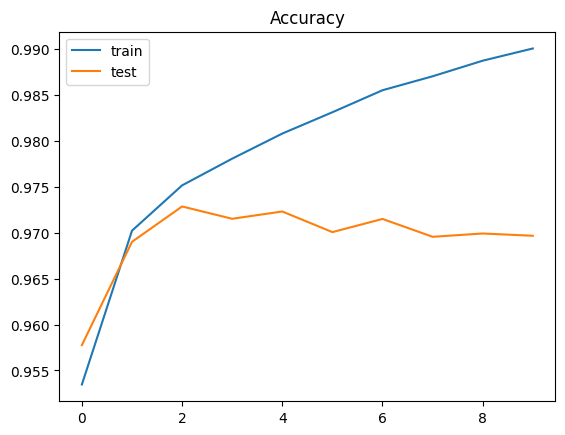

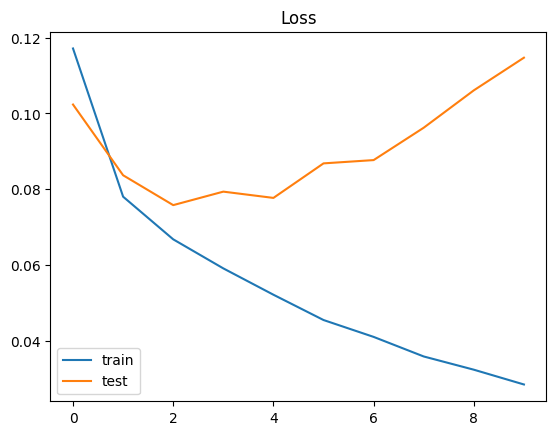

In [31]:
plot_history(history)

Quite overfitted. Training could stop after ~3 epochs and some regularizations (like dropout) could also make sense.  

Let's see if it is possible to further improve the model by unfreezing the embedding layer.

Also see https://www.tensorflow.org/guide/keras/transfer_learning

In [32]:
# Unfreeze all layers (i.e. make embeddings trainable)
training_model.trainable = True
training_model.summary()

Model: "cnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         56937000  
                                                                 
 conv_1 (Conv1D)             (None, None, 128)         268928    
                                                                 
 global_max_pool_1 (GlobalMa  (None, 128)              0         
 xPooling1D)                                                     
                                                                 
 prediction (Dense)          (None, 1)                 129       
                                                                 
Total params: 57,206,057
Trainable params: 57,206,057
Non-trainable params: 0
_________________________________________________________________


In [33]:
re_compile_model(params, training_model)

In [34]:
params["training_epochs"] = 2
history = train_model(params, training_model, dataset_train_preprocessed, dataset_val_preprocessed)

Epoch 1/2
1656/1656 [==============================] - 78s 47ms/step - loss: 0.0178 - accuracy: 0.9943 - val_loss: 0.1023 - val_accuracy: 0.9727
Epoch 2/2
1656/1656 [==============================] - 64s 39ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.1015 - val_accuracy: 0.9730


Let's see how we can make predictions...

... and let's first use the inference model (which is more convenient since it does all in one, i.e. we do not have to care about preprocessing).

In [35]:
%%time

inference_data = ["Ein super Arzt der auf seine Patienten eingeht.", "Ein schlechter Arzt der seinen Patienten nicht zuhört."]

predictions = inference_model.predict(inference_data)

1/1 [==============================] - 0s 403ms/step
CPU times: user 2.03 s, sys: 16.7 ms, total: 2.05 s
Wall time: 2.07 s


... this should also be possible with custom preprocessing and then make predictions with the sub-model we used for training.

In [36]:
%%time

inference_preprocessor = create_text_preprocessor(params, False)

inference_data = ["Ein super Arzt der auf seine Patienten eingeht.", "Ein schlechter Arzt der seinen Patienten nicht zuhört."]
inference_data = inference_preprocessor(inference_data)

predictions = training_model.predict(inference_data)

1/1 [==============================] - 0s 55ms/step
CPU times: user 214 ms, sys: 8.54 ms, total: 223 ms
Wall time: 225 ms


The time difference between the inference model vs. doing a custom preprocessing step does not seem to be huge but when we scale it to a large dataset it can make quite a difference...

In [37]:
%%time

batch_size = params.get("batch_size", 64)
predictions = inference_model.predict(dataset_test.batch(batch_size))

518/518 [==============================] - 65s 125ms/step
CPU times: user 1min 6s, sys: 330 ms, total: 1min 6s
Wall time: 1min 6s


In [38]:
%%time

batch_size = params.get("batch_size", 64)
# we need training here since dataset_test also contains labels
training_preprocessor = create_text_preprocessor(params, True)

dataset_test_preprocessed = dataset_test.batch(batch_size).map(
    training_preprocessor,
    num_parallel_calls=tf.data.AUTOTUNE)

predictions = training_model.predict(dataset_test_preprocessed)

518/518 [==============================] - 2s 5ms/step
CPU times: user 3.57 s, sys: 43.8 ms, total: 3.62 s
Wall time: 2.77 s


As we can see here it can pay of doing a custom preprocessing (~1min vs. ~3sec)

Check performance on all data.

In [39]:
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

2588/2588 [==============================] - 13s 5ms/step
Set Population: 331187
Accuracy: 0.9886


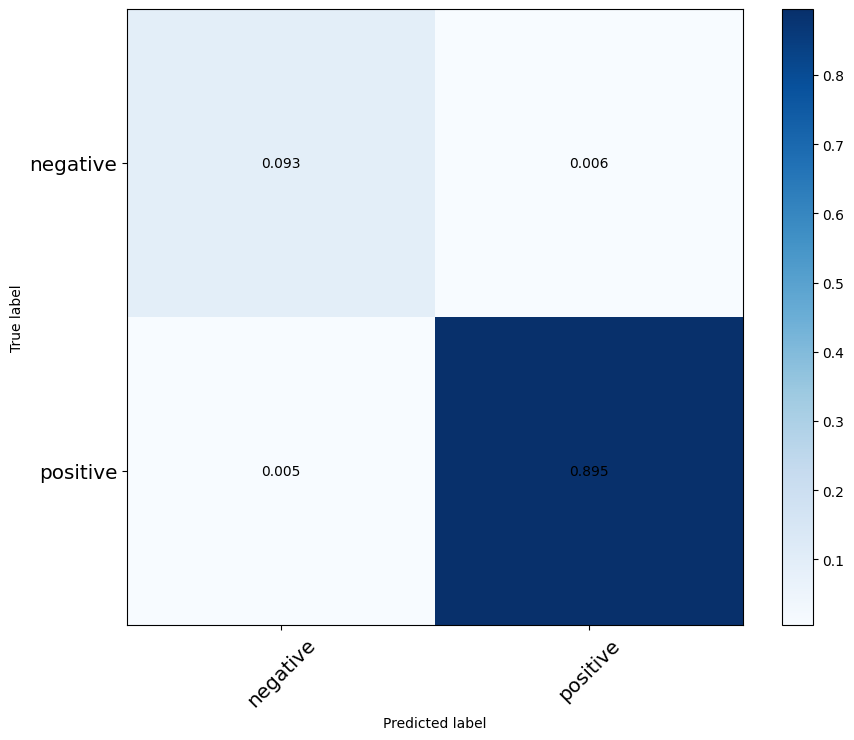

              precision    recall  f1-score   support

    negative       0.95      0.94      0.94     33022
    positive       0.99      0.99      0.99    298165

    accuracy                           0.99    331187
   macro avg       0.97      0.97      0.97    331187
weighted avg       0.99      0.99      0.99    331187

CPU times: user 27.1 s, sys: 829 ms, total: 28 s
Wall time: 23.3 s


In [40]:
%%time

preprocessor = create_text_preprocessor(params, False)

y, y_pred, y_pred_prob = predict_classification(params, data, training_model, preprocessor)

report_classification_results(params, y, y_pred)

Check performance on test data.

518/518 [==============================] - 2s 5ms/step
Set Population: 66238
Accuracy: 0.9722


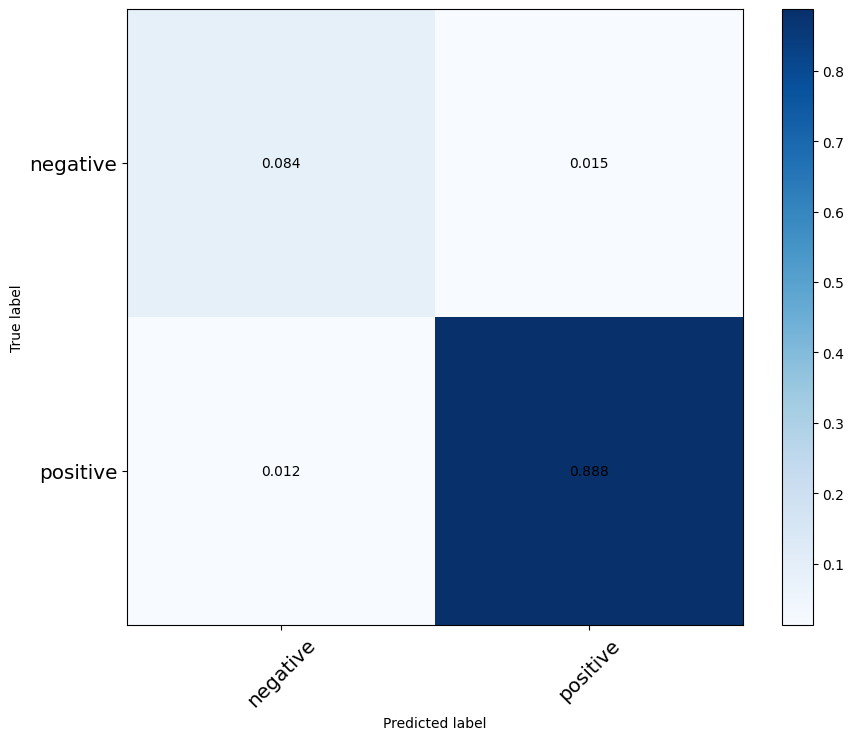

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      6604
    positive       0.98      0.99      0.98     59634

    accuracy                           0.97     66238
   macro avg       0.93      0.92      0.92     66238
weighted avg       0.97      0.97      0.97     66238

CPU times: user 5.26 s, sys: 289 ms, total: 5.55 s
Wall time: 4.42 s


In [41]:
%%time

preprocessor = create_text_preprocessor(params, False)

y, y_pred, y_pred_prob = predict_classification(params, data_test, training_model, preprocessor)

report_classification_results(params, y, y_pred)